In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, 
                                     TimeDistributed, Dropout, Bidirectional,MultiHeadAttention, Attention, Concatenate, LayerNormalization, Add)
from tensorflow.keras.callbacks import EarlyStopping

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 32
FORECAST_STEPS = 32
TEST_RATIO = 0.05
EPOCHS_LIST = [50]
BATCH_SIZES = [128]
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. LOAD AND PREPROCESS DATA
# ========================
df = pd.read_csv('../../data/preprocessed_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
df.drop(columns=['labels'], inplace=True)
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

# List of columns to drop (replace with your actual column names)
columns_to_drop = ['500UZ0009E01.LZI0012A.MEAS', '505D002D01.TI0012.MEAS', '530K001S01.FI0007.MEAS','530R001D01.FIC0029.MEAS']

# Drop them from both train and test dataframes
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)

# ========================
# 3. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(0, len(data) - input_steps - forecast_steps + 1, input_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

X_train_seq, y_train_seq = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)


# ========================
# Model: BiLSTM + Attention
# ========================
def build_lstm_attention_model(input_steps, forecast_steps, input_dim, units=128):
    encoder_inputs = Input(shape=(input_steps, input_dim))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(units, return_sequences=True, return_state=True)
    )(encoder_inputs)

    # Use average encoder output as decoder input context
    context_vector = tf.reduce_mean(encoder_outputs, axis=1)
    decoder_inputs = RepeatVector(forecast_steps)(context_vector)

    decoder_lstm = LSTM(units * 2, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs,
                                   initial_state=[Concatenate()([forward_h, backward_h]),
                                                  Concatenate()([forward_c, backward_c])])

    attention = MultiHeadAttention(num_heads=4, key_dim=units)
    attention_output = attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)

    combined = Concatenate()([decoder_outputs, attention_output])
    combined = LayerNormalization()(combined)

    output = TimeDistributed(Dense(input_dim))(combined)

    model = Model(inputs=encoder_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')  # plain MSE for now
    return model

# ========================
# 5. TRAINING
# ========================
best_val_rmse = np.inf
best_model = None

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\nTraining with epochs={epochs}, batch_size={batch_size}")
        model = build_lstm_attention_model(INPUT_STEPS, FORECAST_STEPS, X_train_seq.shape[2])
        es = EarlyStopping(patience=10, restore_best_weights=True)

        history = model.fit(X_train_seq, y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)

        val_preds = model.predict(X_test_seq, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))

        print(f"Validation RMSE: {val_rmse:.5f}")
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model






Training with epochs=50, batch_size=128
Epoch 1/50
7/7 [==============================] - 27s 735ms/step - loss: 1.7217 - val_loss: 0.6210
Epoch 2/50
7/7 [==============================] - 1s 103ms/step - loss: 0.2508 - val_loss: 0.2675
Epoch 3/50
7/7 [==============================] - 1s 101ms/step - loss: 0.1467 - val_loss: 0.0434
Epoch 4/50
7/7 [==============================] - 1s 105ms/step - loss: 0.0669 - val_loss: 0.0296
Epoch 5/50
7/7 [==============================] - 1s 103ms/step - loss: 0.0237 - val_loss: 0.0255
Epoch 6/50
7/7 [==============================] - 1s 109ms/step - loss: 0.0240 - val_loss: 0.0086
Epoch 7/50
7/7 [==============================] - 1s 101ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 8/50
7/7 [==============================] - 1s 109ms/step - loss: 0.0106 - val_loss: 0.0079
Epoch 9/50
7/7 [==============================] - 1s 108ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 10/50
7/7 [==============================] - 1s 103ms/step - loss: 0.0

In [2]:
# ========================
# 6. SAVE MODEL
# ========================
best_model.save("best_lstm_attention_forecaster.h5")

In [3]:
X_train_seq.shape

(892, 32, 22)

In [4]:
892*32

28544

In [5]:
train_data.shape

(28597, 22)

1/1 [==============================] - 0s 78ms/step


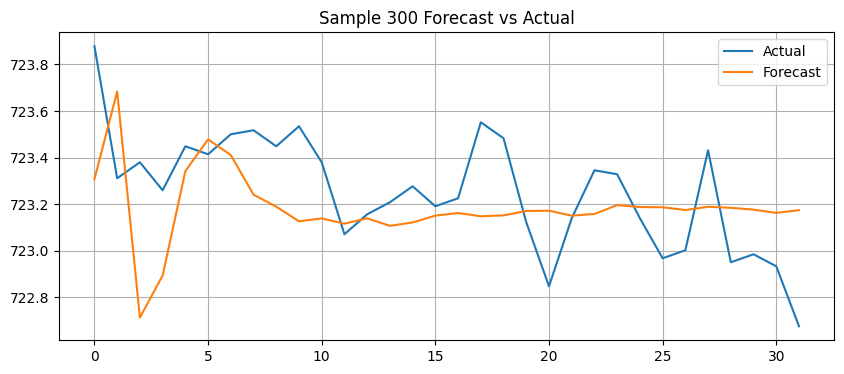

1/1 [==============================] - 0s 78ms/step


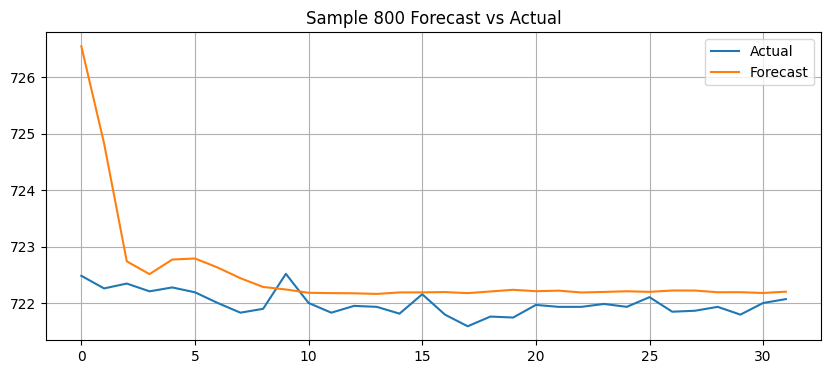

In [8]:
# ========================
# 7. EVALUATION AND PLOTTING
# ========================
def evaluate_sample(index):
    input_seq = np.expand_dims(X_train_seq[index], axis=0)
    prediction = best_model.predict(input_seq)
    pred = prediction.reshape(-1, prediction.shape[2])
    actual = y_train_seq[index]

    pred_denorm = scaler.inverse_transform(pred)
    actual_denorm = scaler.inverse_transform(actual)

    plt.figure(figsize=(10, 4))
    plt.plot(actual_denorm[:, 13], label='Actual')
    plt.plot(pred_denorm[:, 13], label='Forecast')
    plt.title(f'Sample {index} Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare two samples visually
evaluate_sample(300)
evaluate_sample(800)


In [9]:
X_train_seq.shape

(892, 32, 22)

In [10]:
#y_pred_reshaped2 = X_test_seq[6197].reshape(-1, X_test_seq[6197].shape[2])
denorm2 = scaler.inverse_transform(X_train_seq[400])
denorm_df2 = pd.DataFrame(denorm2, columns=df.columns)

In [12]:
input_seq1 = np.expand_dims(X_train_seq[400], axis=0)
val_preds2 = model.predict(input_seq1, batch_size=128)
y_pred_reshaped = val_preds2.reshape(-1, val_preds2.shape[2])
denorm = scaler.inverse_transform(y_pred_reshaped)
denorm_df = pd.DataFrame(denorm, columns=df.columns)

1/1 [==============================] - 0s 68ms/step


In [13]:
denorm_df2

,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,530R001D02.FIC0230.MEAS,530R002D02.LI0010.MEAS,530M102D01.LIC0011.MEAS,...,530F001D01.PIC0023.MEAS,530R002D02.TI0037.MEAS,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS
0,4.471129,128.091797,2647.385742,1200.272095,2607.422363,309.862122,131.517624,5.471328,52.882294,30.213318,...,1.495781,721.609375,142.187500,680.642578,159.404785,19.337891,15.835938,59.367188,12.852097,57.847656
1,4.471129,128.091797,2645.835449,1197.998535,2606.188721,309.601929,131.556564,5.471328,52.211979,29.913111,...,1.495781,721.403137,142.250000,681.181641,159.798538,19.591797,15.835938,59.167969,12.751553,57.740234
2,4.471129,128.091797,2652.385742,1203.489136,2607.712158,309.923248,131.331726,5.471328,51.898308,29.114435,...,1.495781,721.489075,142.406250,681.032227,159.929794,19.523438,15.835938,59.367188,12.750025,57.843750
3,4.471129,128.091797,2649.905762,1199.852173,2603.324951,309.003540,131.658951,5.471328,53.475334,30.292913,...,1.495781,721.454712,142.531250,680.909180,159.929794,19.695312,15.835938,59.480469,12.851550,57.843750
4,4.471129,128.208984,2645.013428,1199.342041,2601.482910,310.049713,131.923569,5.471328,53.274857,29.541897,...,1.495781,721.454712,142.656250,680.800781,159.798538,19.263672,15.835938,59.501949,12.856457,57.843750
5,4.471129,128.208984,2650.170654,1198.618530,2603.790771,310.385986,131.990540,5.471328,53.177643,28.672731,...,1.495781,721.798462,142.765625,681.360352,159.798538,19.763672,15.835938,59.332031,12.970817,57.843750
6,4.471129,128.226562,2644.893311,1200.375000,2606.750488,309.349304,131.713867,5.471328,53.926815,29.482500,...,1.495781,721.729675,143.046875,681.266602,159.667282,19.314451,15.835938,59.640625,12.957440,57.843750
7,4.471129,127.769531,2654.659668,1202.360962,2602.834229,308.521545,131.903946,5.471328,51.172668,31.025150,...,1.495781,721.660950,143.125000,681.257812,159.798538,19.693359,15.835938,59.126953,12.955154,57.738281
8,4.471129,127.769531,2646.317871,1197.368408,2603.437012,313.433136,131.630142,5.471328,53.929981,30.398769,...,1.495781,721.437500,143.343750,681.161133,159.798538,19.517578,15.835938,59.435547,12.949687,57.839844
9,4.471129,127.875000,2649.497803,1202.214722,2605.365479,313.485931,131.791428,5.471328,53.100975,30.947489,...,1.495781,721.489075,143.453125,681.161133,159.798538,19.515625,15.835938,59.638676,12.851465,57.955078


In [14]:
denorm_df

,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,530R001D02.FIC0230.MEAS,530R002D02.LI0010.MEAS,530M102D01.LIC0011.MEAS,...,530F001D01.PIC0023.MEAS,530R002D02.TI0037.MEAS,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS
0,4.391537,117.516243,2649.018311,1166.981689,2669.777344,307.822174,125.731720,6.249969,55.021225,31.733849,...,1.469094,721.849365,171.795044,684.844116,161.752487,19.184828,13.331653,60.170891,13.014678,58.409645
1,4.459023,120.311211,2647.929443,1174.161499,2650.613037,308.878143,128.654449,5.806333,53.709305,29.896049,...,1.463184,723.358521,156.631744,682.758423,160.318604,19.595749,13.874387,59.565746,12.973685,58.370476
2,4.476262,120.627678,2650.122070,1190.208252,2626.850586,308.860809,128.912598,5.808505,52.699100,29.629183,...,1.477575,722.792786,149.178055,682.353455,158.897202,19.476221,14.290089,59.324814,13.004272,58.146862
3,4.468682,120.863083,2649.678467,1198.378906,2615.952148,309.081085,129.237411,5.838550,52.587662,29.909813,...,1.484040,723.065186,146.289810,682.037292,158.252060,19.473831,14.704208,59.358501,13.027366,58.075630
4,4.465015,121.400490,2648.242676,1200.363770,2612.071533,309.340393,129.799805,5.756186,52.623909,30.022003,...,1.484970,723.365967,145.358521,681.921326,158.237808,19.568209,15.024136,59.504772,13.033449,58.092247
5,4.465915,122.344307,2647.603760,1200.121582,2610.808350,309.477051,130.250595,5.642566,52.521793,29.950188,...,1.484407,723.302856,144.725891,682.077515,158.387955,19.676838,15.242060,59.605492,13.027987,58.121410
6,4.470669,123.061501,2647.647949,1199.229858,2609.623535,309.495789,130.535065,5.567947,52.342236,29.826935,...,1.483058,723.017883,144.219910,682.236511,158.547806,19.753923,15.332980,59.678944,13.024382,58.139862
7,4.473951,123.491737,2647.815186,1198.240479,2609.163574,309.455444,130.686127,5.536005,52.233288,29.727852,...,1.482422,722.733459,144.388489,682.374939,158.627975,19.795938,15.382478,59.720490,13.023802,58.142712
8,4.475399,123.817360,2648.017334,1197.233032,2608.826660,309.395050,130.817520,5.539741,52.141087,29.693708,...,1.481702,722.527771,144.433273,682.426392,158.695328,19.817072,15.398113,59.719913,13.024072,58.148685
9,4.476965,124.115074,2648.110840,1197.009033,2608.934814,309.354126,130.837082,5.553824,52.125183,29.623295,...,1.481656,722.371521,144.866440,682.465454,158.700409,19.821207,15.399381,59.723701,13.025028,58.145634
